[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mauro-moura/GA-023/blob/main/q1.ipynb)

In [ ]:
!pip install --upgrade deeplake==3 

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from scipy.fftpack import fft2, fftshift

In [ ]:
from PIL import Image
import numpy as np

from numba import jit, prange

@jit(nopython=True, parallel=True)
def convert_images(ds_full: np.ndarray):
    images = np.empty((len(ds_full), 100, 100), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i].numpy()
        img = Image.fromarray(img)
        img = img.resize((100, 100))
        img = img.convert('L')
        images[i] = np.array(img)
    
    return images

def load_data(size=100, lim=100, use_jit=False):
    import deeplake

    # Load the FFHQ dataset
    ds = deeplake.load("hub://activeloop/ffhq")

    ds_full = ds['images_1024']['image'][:lim].numpy()

    if use_jit:
        images = convert_images(ds_full)
        return images

    images = np.empty((len(ds_full), size, size), dtype=np.uint8)
    for i in prange(len(ds_full)):
        img = ds_full[i]
        img = Image.fromarray(img)
        img = img.resize((size, size))
        img = img.convert('L')
        images[i] = np.array(img)

    return images


In [ ]:
BASE_OUTPUT_FOLDER = os.path.joins('results', 'q1')
if not os.path.exists(BASE_OUTPUT_FOLDER):
  os.makedirs(BASE_OUTPUT_FOLDER)

In [ ]:
def gaussian_2d(x, y, sigma):
    return (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

def gaussian_derivative(x, y, sigma, axis):
    gaussian = gaussian_2d(x, y, sigma)
    if axis == 'x':
        return -x / sigma**2 * gaussian
    elif axis == 'y':
        return -y / sigma**2 * gaussian

def generate_filter(size, sigma):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    gaussian_filter = gaussian_2d(x, y, sigma)
    gaussian_filter /= np.sum(gaussian_filter)  # Normalize
    return gaussian_filter

def generate_derivative_filter(size, sigma, axis):
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    return gaussian_derivative(x, y, sigma, axis)

In [4]:
image_array_list = load_data(size=100, lim=10)

/home/mauro/miniconda3/envs/disciplinas/lib/python3.11/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (4.0.3) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


hub://activeloop/ffhq loaded successfully.
This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/ffhq


In [5]:
image_array = image_array_list[0]

In [6]:
# Parameters
size = 5  # Filter size
sigma = 1  # Standard deviation for Gaussian

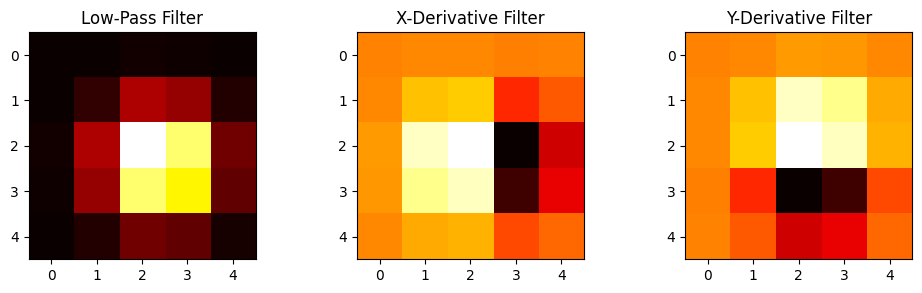

In [12]:
low_pass_filter = generate_filter(size, sigma)
x_derivative_filter = generate_derivative_filter(size, sigma, 'x')
y_derivative_filter = generate_derivative_filter(size, sigma, 'y')

# Display filters
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.imshow(low_pass_filter, cmap='hot')
plt.title('Low-Pass Filter')

plt.subplot(1, 3, 2)
plt.imshow(x_derivative_filter, cmap='hot')
plt.title('X-Derivative Filter')

plt.subplot(1, 3, 3)
plt.imshow(y_derivative_filter, cmap='hot')
plt.title('Y-Derivative Filter')

plt.tight_layout()

plt.savefig(f'results/q1/filters_size_{size}_sigma_{sigma}.png', bbox_inches='tight')
plt.show()

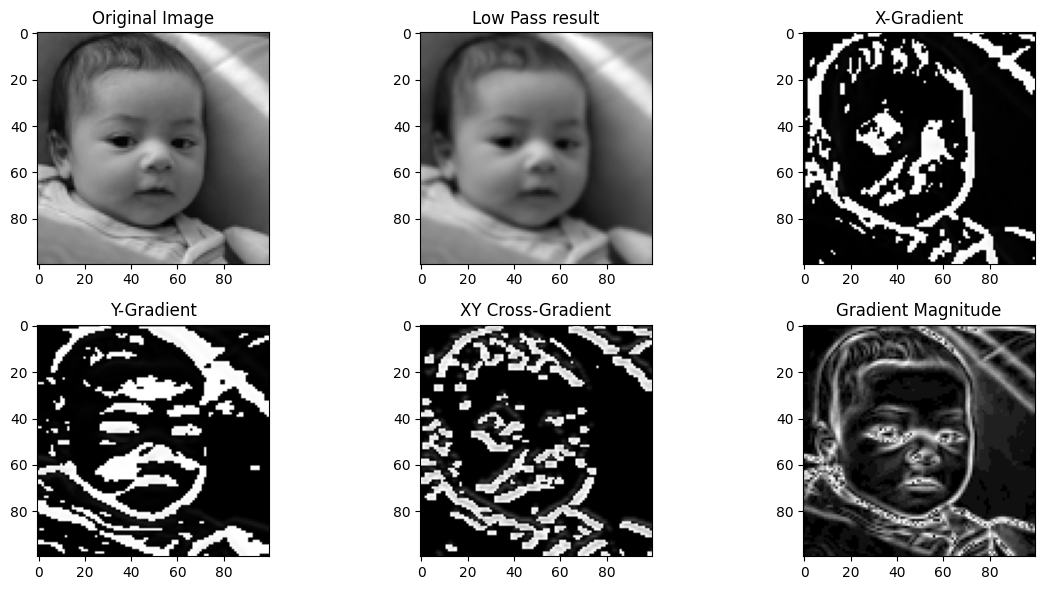

In [11]:
low_pass_result = convolve(image_array, low_pass_filter)
x_gradient_result = convolve(image_array, x_derivative_filter)
y_gradient_result = convolve(image_array, y_derivative_filter)

xy_gradient_result = convolve(convolve(image_array, x_derivative_filter), y_derivative_filter)
gradient_magnitude = np.sqrt(x_gradient_result**2 + y_gradient_result**2)

plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(low_pass_result, cmap='gray')
plt.title('Low Pass result')

plt.subplot(2, 3, 3)
plt.imshow(x_gradient_result, cmap='gray')
plt.title('X-Gradient')

plt.subplot(2, 3, 4)
plt.imshow(y_gradient_result, cmap='gray')
plt.title('Y-Gradient')

plt.subplot(2, 3, 5)
plt.imshow(xy_gradient_result, cmap='gray')
plt.title('XY Cross-Gradient')

plt.subplot(2, 3, 6)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude')

plt.tight_layout()

plt.savefig(f'results/q1/gradient_filters_size_{size}_sigma_{sigma}.png', bbox_inches='tight')
plt.show()